# 4.1-2a MCMC Implementation Problems

In [0]:
#@title Import { display-mode: "form" }

import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()
import tensorflow_probability as tfp

%matplotlib inline
tfd = tfp.distributions
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

# Problem 1:

Go to https://people.duke.edu/~ccc14/sta-663/MCMC.html and read section Metropolis-Hastings sampler. <br>
A.Run Metropolis sampler code and:<br>
1. Analyze how variance of the proposal distribution sigma affects the sampling
2. Suggest another proposal distribution and analyze quality of sampling
3. Consider PyMC3 implementation of the problem - please see for example https://people.duke.edu/~ccc14/sta-663/PyMC3.html . Then, using PyMC3 documentation http://docs.pymc.io/api/inference.html#module-pymc3.sampling (find Metropolis) modify the parameters of the sampler and repeat steps 1 and 2.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


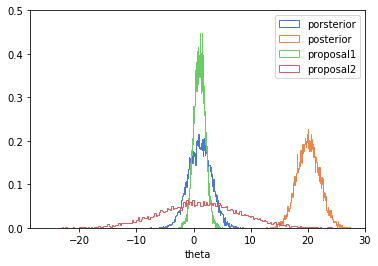

In [0]:
# a

# If we consider the following posterior shape:

n_sampels = 10000

mean1 = 1                              
variance1 = 4
std1 = np.sqrt(variance1)                
y1 = np.random.normal(mean1,std1,n_sampels) 

mean2 = 20                              
variance2 = 4
std2 = np.sqrt(variance2)                
y2 = np.random.normal(mean2,std2,n_sampels) 

posterior = y1 + y2

mean_p1 = 1
variance_p1 = 1
std_p1 = np.sqrt(variance_p1)                
proposal1 = np.random.normal(mean_p1,std_p1,n_sampels) 

mean_p2 = 1                              
variance_p2 = 50
std_p2 = np.sqrt(variance_p2)                
proposal2 = np.random.normal(mean_p2,std_p2,n_sampels) 

plt.hist(y1, bins=200, normed=True, histtype='step', lw=1)  
plt.hist(y2, bins=200, normed=True, histtype='step', lw=1) 

plt.hist(proposal1, bins=200, normed=True, histtype='step', lw=1) 
plt.hist(proposal2, bins=200, normed=True, histtype='step', lw=1) 

plt.ylim(0, .5)
plt.legend(['porsterior', 'posterior', 'proposal1', 'proposal2'])
plt.xlabel("theta")
plt.show()

Therefore, if we consider we have a posterior function like the one present above (the blue and the green curves). then if we select a proposal (similar to the red function, which is a normal distribution), it is clear that it has a small variance. Therefore, any sampled next step is going to lie in vacinity of the original chosen theta. Therefore, there is a very bad chance of picking a number that falls between 10 and 30 in order to explore the other part of the posterior. Therefore, it is going to take a long time to explore the other part of the posterior given above. On the other hand, if we chosen an initial proposal whos variance is large, to be able to explore the other part of the posterior, many samples will be rejected. For instance, we will get many samples maybe in the range -20 to -5, and from 5 to 15. Almost, many of these samples will be rejected. 

Again, the since the acceptance ratio is given by $\frac{P(x')}{P(x)}$, hence, whenever the sampled value doesn't lie in the range of insterest, its probability will be less than that of x. For example, the pdf based on the posterior of -10 is way smaller than that at ~0 or ~20. Hence, the result will be a very small number, which will be picked only if we were lucky and the output of the uniform was smaller.

In [0]:
# Now if we consider the given code:

# lik: likelihood, h: head, n: number of samples, target is the posterior distribution. 
def target(lik, prior, n, h, theta):
    if theta < 0 or theta > 1:
        return 0
    else:
        return lik(n, theta).pmf(h)*prior.pdf(theta)

n = 100
h = 61
a = 10
b = 10
# likelihood follows a binomial distribution...
lik = stats.binom
prior = stats.beta(a, b)
sigma = 0.3

# number of accepted samples.
naccept = 0
theta = 0.1
niters = 10000
samples = np.zeros(niters+1)
samples[0] = theta
for i in range(niters):
    # The proposal distribution is Normal with mean theta and std sigma. 
    theta_p = theta + stats.norm(0, sigma).rvs()  
    rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta
nmcmc = len(samples)//2
print ("Efficiency = ", naccept/niters)

Efficiency =  0.1872


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


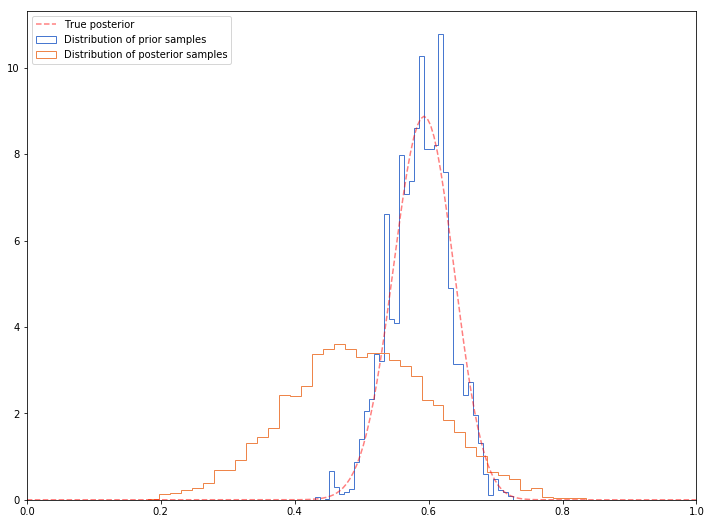

In [0]:
# this is the true posterior posterior.
post = stats.beta(h+a, n-h+b)
thetas = np.linspace(0, 1, 200)

plt.figure(figsize=(12, 9))
plt.hist(samples[nmcmc:], 40, histtype='step', normed=True, linewidth=1, label='Distribution of prior samples');
# prior.rvs(nmcmc): will generate nmcmc random numbers. 
plt.hist(prior.rvs(nmcmc), 40, histtype='step', normed=True, linewidth=1, label='Distribution of posterior samples');
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,1]);
plt.legend(loc='best');

In [0]:
def mh_coin(niters, n, h, theta, lik, prior, sigma):
    samples = [theta]
    while len(samples) < niters:
        theta_p = theta + stats.norm(0, sigma).rvs()
        rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
        u = np.random.uniform()
        if u < rho:
            theta = theta_p
        samples.append(theta)
    return samples

In [0]:
n = 100
h = 61
lik = stats.binom
prior = stats.beta(a, b)
sigma = 0.05
niters = 100

sampless = [mh_coin(niters, n, h, theta, lik, prior, sigma) for theta in np.arange(0.1, 1, 0.2)]

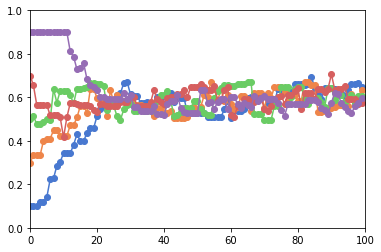

In [0]:
# Convergence of multiple chains

for samples in sampless:
    plt.plot(samples, '-o')
plt.xlim([0, niters])
plt.ylim([0, 1]);

So the efficiency showed above: 0.1896 ~ 19% is a very low number. Hence the effective sample size is very low. Therefore, we need to chose an alternative proposal density function. The new proposed one has a sigma of 0.01 as shown below

In [0]:
# Now if we consider the given code:

# lik: likelihood, h: head, n: number of samples, target is the posterior distribution. 
def target(lik, prior, n, h, theta):
    if theta < 0 or theta > 1:
        return 0
    else:
        return lik(n, theta).pmf(h)*prior.pdf(theta)

n = 100
h = 61
a = 10
b = 10
# likelihood follows a binomial distribution...
lik = stats.binom
prior = stats.beta(a, b)
sigma = 0.01

# number of accepted samples.
naccept = 0
theta = 0.1
niters = 10000
samples = np.zeros(niters+1)
samples[0] = theta
for i in range(niters):
    # The proposal distribution is Normal with mean theta and std sigma. 
    theta_p = theta + stats.norm(0, sigma).rvs()  
    rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta
nmcmc = len(samples)//2
print ("Efficiency = ", naccept/niters)

Efficiency =  0.9209


When chosing a sigma of 0.1 we get efficiency of 0.4691 which is still low. By chosing a sigma of 0.05, we get an effociency of 0.6736 which is better. After choosing a sigma of 0.02, we get efficiency of 0.8541 which is a very good choice. And sigma = 0.01 gives an efficiency of 0.9289 which is even better. 

### Build the model in PyMC3

In [0]:
n = 100
h = 61
alpha = 10
beta = 10

niter = 10000

with pm.Model() as model: # context management
    # define priors
    p = pm.Beta('p', alpha=alpha, beta=beta)

    # define likelihood
    y = pm.Binomial('y', n=n, p=p, observed=h)
    
    # inference
    start = pm.find_MAP() # Use MAP estimate (optimization) as the initial state for MCMC
#     step = pm.Metropolis() # Have a choice of samplers
    step_ = pm.step_methods.metropolis.Metropolis(S=np.array([1]))
    # sample will draw from the posterior. 
    trace = pm.sample(niter, step_, start, random_seed=123, progressbar=True, njobs=4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p,0.591281,0.043954,0.000555,0.506703,0.677616,6300.0,1.000227


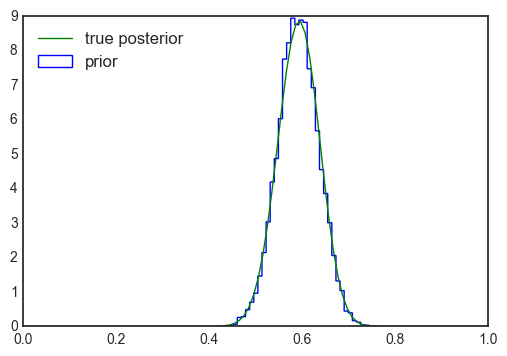

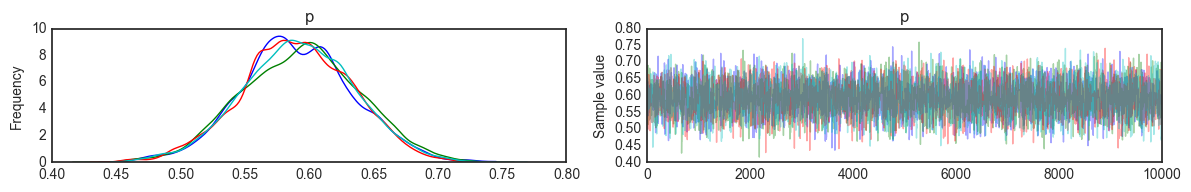

In [0]:
plt.hist(trace['p'], 40, histtype='step', normed=True, label='prior');
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, h + alpha, n - h + beta), label='true posterior');
# plt.hist(trace[''], 40, histtype='step', normed=True, label='Posterior')
plt.legend(loc='best');

_ = pm.traceplot(trace)

pm.summary(trace)

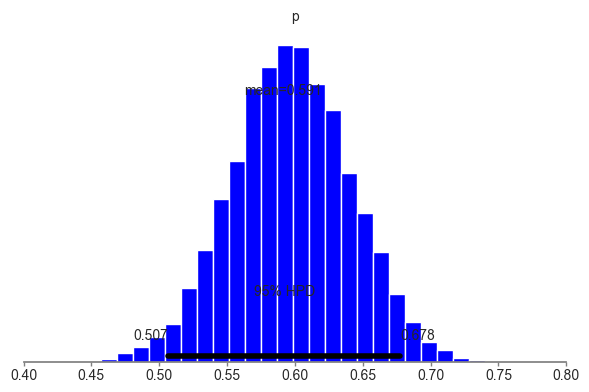

In [0]:
pm.plot_posterior(trace)

### Build the model in Tensorflow

In [0]:
###====================== Observed Data ==============================
n = 100
h = 61.
true_alpha = 10.
true_beta = 10.

with pm.Model() as model: # context management
    # define priors
    p = pm.Beta('p', alpha=alpha, beta=beta)

    # define likelihood
    y = pm.Binomial('y', n=n, p=p, observed=h)
    
    # inference
    start = pm.find_MAP() # Use MAP estimate (optimization) as the initial state for MCMC
#     step = pm.Metropolis() # Have a choice of samplers
    step_ = pm.step_methods.metropolis.Metropolis(S=np.array([1]))
    # sample will draw from the posterior. 
    trace = pm.sample(niter, step_, start, random_seed=123, progressbar=True, njobs=4)
    


In [0]:
###=================== Define the model ==========================
def joint_log_prob(p, y):
  
  # prior
  rv_p = tfd.Beta(10., 10.) 
  
  # likelihood
  rv_y = tfd.Binomial(total_count=100., probs=p)
   
  return (rv_p.log_prob(p) + rv_y.log_prob(y))

def unnormalized_posterior(p):
  return joint_log_prob(p, h)

In [0]:
###=================== Sample the model =====================

# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(1e3)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Wrap sample_chain in function
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
  
  is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  
  return samples, is_accepted

# Set the initial value
init_p = tf.zeros(1)

# Call run_chain
initial_state = init_p
samples, is_accepted = run_chain()
sampled_p = samples

W0820 13:15:31.875749 140417899677568 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:2403: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


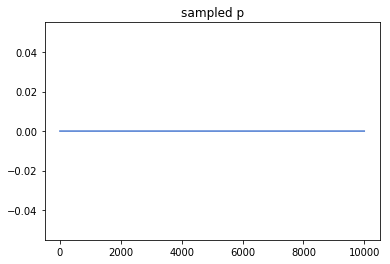

In [0]:
###=================== Trace the sampling =====================

# Plot sampled p
plt.plot(sampled_p, label="sampled_p")
plt.title("sampled p")
plt.show()

We can see that the there is no pattern in the samples hence, we can assume that we have astimated truely the posterior distribution. But, on the other hand, the number of effective samples is smaller than 25%for some parameter as mentioned above. Therefore, we need to change the proposal density as an attempt to getting more samples. 

Note that based on the documentation of the Metropolis Hastings provided in https://github.com/pymc-devs/pymc3/blob/master/pymc3/step_methods/metropolis.py, the proposal density is set to be a normal distribution with std=1 for each variable by default. 

# Problem 2:

Run Metropolis Hastings sampling algorithm of size 5000 to sample from the following posterior distribution:
$$p(\theta)= 0.6*e^{-\theta^2/2}+0.2*e^{-(\theta-3)^2/8}$$
You can use PyMC3 (for example see Sampler statistics https://docs.pymc.io/notebooks/sampler-stats.html). Analyze the following:
1. Autocorellation plot
2. Gelma-rubin
3. HPD
4. Effective size <br>
You can find code for that in chapter 2 of Bayesian analysis with Python.


The distribution can be shown as a mixture of two Gaussian distributions:
$$p(\theta)= 0.6*e^{-\theta^2/2}+0.4*(\frac{1}{2}e^{-\frac{1}{2*2^2}(\theta-3)^2})$$

### Implementation in PyMC3

In [0]:
model = pm.Model()
with model:
  m= pm.NormalMixture('m', mu=np.array([0., 3.]), w=np.array([.6, 0.4]), sd=np.array([1., 2.]))
  step = pm.Metropolis()
  trace = pm.sample(5000, init=None, step=step, njobs=4)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022226CEF8D0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000022226D41BA8>]], dtype=object)

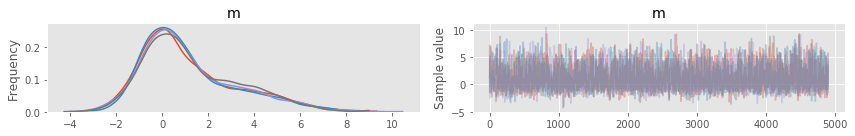

In [0]:
burnin = 100
chain = trace[burnin:]
pm.traceplot(chain)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022225BEB400>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000022226E89B00>]], dtype=object)

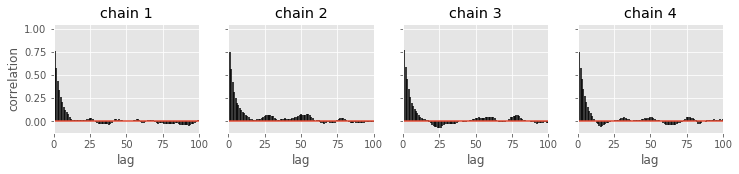

In [0]:
#1
pm.plots.autocorrplot(trace, varnames=None, max_lag=100, burn=0, plot_transformed=False, symmetric_plot=False, ax=None, figsize=None)

we can see that the two chains all drop to low value very quickly.

In [0]:
#2
pm.diagnostics.gelman_rubin(trace, varnames=None, include_transformed=False)

{'m': 1.0000}

the value of gelman_rubin is almost 1,the convergence is quite good

In [0]:
#3
pm.stats.hpd(trace)

{0: {'m': array([-2.0949,  5.613 ])},
 1: {'m': array([-1.9377,  5.5182])},
 2: {'m': array([-2.4087,  5.5103])},
 3: {'m': array([-2.1734,  5.4333])}}

for the chain 0,The values between -1.6313,  5.7664 here have the highest posterior density,and for chain 1,The values between -2.2366,  5.2869 here have the highest posterior density.

In [0]:
#4
pm.diagnostics.effective_n(trace, varnames=None, include_transformed=False)

{'m': 2676.0000}

2676 iterations is enough for a reasonable estimate of the posterior mean.

### Implementation in Tensorflow

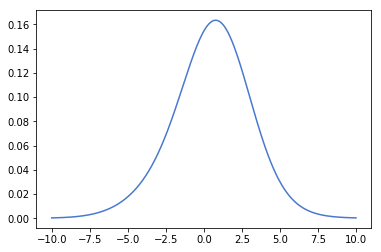

In [0]:
###=================== Define the model =====================
unnormalized_posterior = tfd.Mixture(
  cat=tfd.Categorical(probs=[0.6, 1.-0.4]),
  components=[
    tfd.Normal(loc=0., scale=3.),
    tfd.Normal(loc=1., scale=2.),
])

# Plot the PDF.
x = tf.linspace(-10., 10., int(1e4))
plt.plot(x, unnormalized_posterior.prob(x))
plt.title("true m")

In [0]:
###=================== Sample the model =====================

# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(1e3)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior.log_prob,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Wrap sample_chain in function
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
  
  is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  
  return samples, is_accepted

# Call run_chain
initial_state = tf.zeros(1)
samples, is_accepted = run_chain()

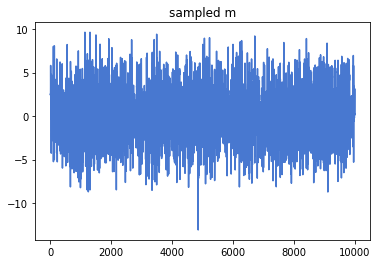

In [0]:
###=================== Trace the sampling =====================

# Plot sampled m
plt.plot(samples, label="sampled m")
plt.title("sampled m")
plt.show()

# Problem 3:


For the implementation of coin flip from Chapter 2 of the book Bayesian analysis with Python, please do the following:
1. Replace the beta distribution with a uniform one in the interval [0,1]. Are the results equivalent to Beta(1, 1). Is the sampling slower, faster, or the same? What about using a larger interval such as [-1, 2]? Does the model run? What errors do you get? And what do you get if you don't use find_MAP()?

2. Modify the amount of burnin. Try it with values such as 0 and 500. Try it also with and without the find_MAP() function. How different are the results? 


**Please answer this problem by adding cells here.** $$ $$

### 3.1) Replacing the beta distribution with a uniform one in the interval [0,1]

1. Implement in PyMC3

In [0]:
np.random.seed(123)
n_experiments = 4
theta_real = 0.35  # unkwon value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)
data

array([1, 0, 0, 0])

In [0]:
with pm.Model() as our_first_model:
    # a priori
    theta = pm.Uniform('theta', lower=0, upper=1)   # here we are replacing the beta distribution with uniform[0,1]
    # likelihood
    y = pm.Bernoulli('y', p=theta, observed=data)
    #y = pm.Binomial('theta',n=n_experimentos, p=theta, observed=sum(datos))
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, start=start)

logp = -2.7726, ||grad|| = 1: 100%|█████████████████████████████████████████████████████| 6/6 [00:00<00:00, 545.30it/s]
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [theta_interval__]
The number of effective samples is smaller than 25% for some parameters.


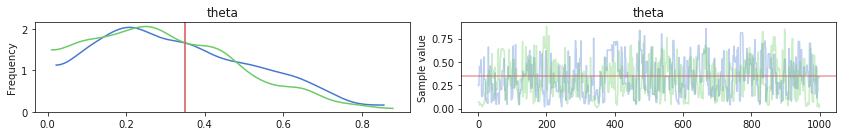

In [0]:
burnin = 0  # no burnin
chain = trace[burnin:]
pm.traceplot(chain, lines={'theta':theta_real});
plt.savefig('B04958_02_04.png', dpi=300, figsize=(5.5, 5.5))

THe plot on the left side is KDE PLots. KDE plots should look like smooth curves. Often, as the number of data increases, the distribution of each parameter will tend to become Gaussian-like; this is due to the law of the large numbers. Of course, this is not always true. The plot on the right should look like white noise; we are looking for good mixing. We should not see any recognizable pattern, we should not see a curve going up or down, instead we want a curve meandering around a single value.

2. Implement in tensorflow

In [41]:
###====================== Generated data for the model ==============================
np.random.seed(123)
n_experiments = 4
true_theta = 0.35  # unkwon value in a real experiment
true_y = np.random.binomial(n=n_experiments, p=true_theta)
data = stats.bernoulli.rvs(p=true_theta, size=n_experiments)

print("The data set generated is:", data)

The data set generated is: [0 0 0 1]


In [0]:
###=================== Define the model ==========================
def joint_log_prob(theta, y):
  
  # prior
  rv_theta = tfd.Uniform(low=0., high=1.)
  
  # likelihood
  rv_y = tfd.Bernoulli(theta)
   
  return (rv_theta.log_prob(theta) + rv_y.log_prob(y))

def unnormalized_posterior(theta):
  return joint_log_prob(theta, true_y)

In [0]:
###=================== Sample the model =====================

# Initialize the HMC transition kernel.
num_results = int(10e2)
num_burnin_steps = int(1e3)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Wrap sample_chain in function
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
  
  is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  
  return samples, is_accepted

# Call run_chain
initial_state = tf.zeros(1)
samples, is_accepted = run_chain()
sampled_theta = samples

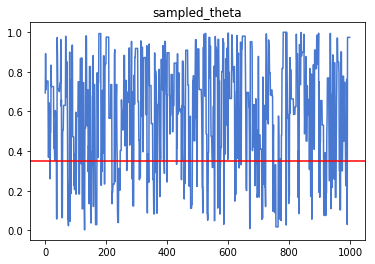

In [44]:
###=================== Trace the sampling =====================

# Plot sampled theta
plt.plot(sampled_theta, label="sampled_theta")
plt.axhline(y=true_theta, color="red")
plt.title("sampled_theta")
plt.show()

### by taking beta distribution of [1,1]

1. Implement in PyMC3

In [0]:
np.random.seed(123)
n_experiments = 4
theta_real = 0.35  # unkwon value in a real experiment
true_y = np.random.binomial(n=n_experiments, p=true_theta)
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)
data

array([0, 0, 0, 1])

In [0]:
with pm.Model() as our_first_model:
    # a priori
    theta = pm.Beta('theta', alpha=1, beta=1)  # here we are using the beta distribution with alpha=1 and beta=1
    # likelihood
    y2 = pm.Bernoulli('y2', p=theta, observed=data)
    #y = pm.Binomial('theta',n=n_experimentos, p=theta, observed=sum(datos))
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, start=start)

logp = -2.7726, ||grad|| = 1: 100%|█████████████████████████████████████████████████████| 6/6 [00:00<00:00, 428.36it/s]
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [theta_logodds__]
The number of effective samples is smaller than 25% for some parameters.


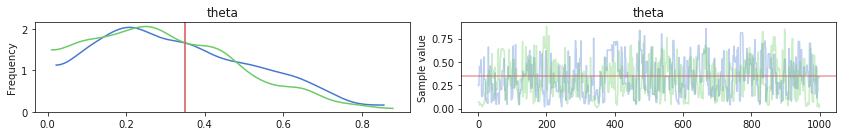

In [0]:
burnin = 0  # no burnin
chain = trace[burnin:]
pm.traceplot(chain, lines={'theta':theta_real});
plt.savefig('B04958_02_04.png', dpi=300, figsize=(5.5, 5.5))

**By seeing the resulting of replacing the beta distribution with uniform[0,1] and taking the beta distribution of [1,1] we can observe that the sampling rate for the unifrom[0,1] is 545.30it/s and the sampling rate for the beta[1,1] is 428.36it/s .From this we can say that the sample rate is increases if the beta distribution[0,1] is replaced by uniform distribution [1,1] **

2. Implement in tensorflow

In [45]:
###====================== Generated data for the model ==============================
np.random.seed(123)
n_experiments = 4
true_theta = 0.35  # unkwon value in a real experiment
true_y = np.random.binomial(n=n_experiments, p=true_theta)
data = stats.bernoulli.rvs(p=true_theta, size=n_experiments)

print("The data set generated is:", data)

The data set generated is: [0 0 0 1]


In [0]:
###=================== Define the model ==========================
def joint_log_prob(theta, y):
  
  # prior
  rv_theta = tfd.Beta(1., 1.)
  
  # likelihood
  rv_y = tfd.Bernoulli(theta)
   
  return (rv_theta.log_prob(theta) + rv_y.log_prob(y))

def unnormalized_posterior(theta):
  return joint_log_prob(theta, true_y)

In [0]:
###=================== Sample the model =====================

# Initialize the HMC transition kernel.
num_results = int(10e2)
num_burnin_steps = int(1e3)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Wrap sample_chain in function
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
  
  is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  
  return samples, is_accepted

# Call run_chain
initial_state = tf.zeros(1)
samples, is_accepted = run_chain()
sampled_theta = samples

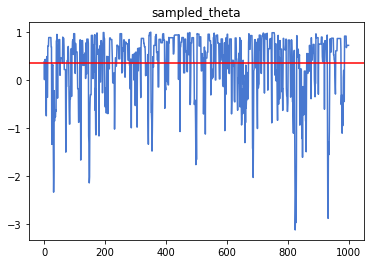

In [48]:
###=================== Trace the sampling =====================

# Plot sampled theta
plt.plot(sampled_theta, label="sampled_theta")
plt.axhline(y=true_theta, color="red")
plt.title("sampled_theta")
plt.show()

### by taking the larger interval in uniform distribution [-1,2]

1. Implement in PyMC3

In [6]:
np.random.seed(123)
n_experiments = 4
theta_real = 0.35  # unkwon value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)
data

array([1, 0, 0, 0])

In [0]:
with pm.Model() as our_first_model:
    # a priori
    theta = pm.Uniform('theta', lower=-1, upper=2)  # here we are replacing the beta distribution with uniform[-1,2]
    # likelihood
    y3 = pm.Bernoulli('y3', p=theta, observed=data)
    #y = pm.Binomial('theta',n=n_experimentos, p=theta, observed=sum(datos))
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, start=start)

logp = -3.8712, ||grad|| = 3: 100%|█████████████████████████████████████████████████████| 3/3 [00:00<00:00, 333.08it/s]
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [theta_interval__]
The estimated number of effective samples is smaller than 200 for some parameters.


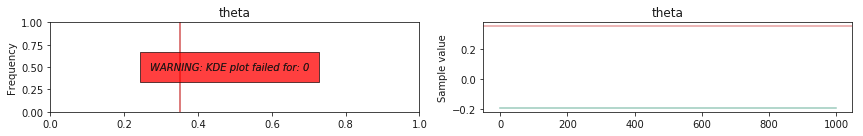

In [0]:
burnin = 0  # no burnin
chain = trace[burnin:]
pm.traceplot(chain, lines={'theta':theta_real});
plt.savefig('B04958_02_04.png', dpi=300, figsize=(5.5, 5.5))

** From the results of Uniform distribution with larger interval [-1,2] we can say that the model is  running without any error**

2. Implement in Tensorflow

In [49]:
###====================== Generated data for the model ==============================
np.random.seed(123)
n_experiments = 4
true_theta = 0.35  # unkwon value in a real experiment
true_y = np.random.binomial(n=n_experiments, p=true_theta)
data = stats.bernoulli.rvs(p=true_theta, size=n_experiments)

print("The data set generated is:", data)

The data set generated is: [0 0 0 1]


In [0]:
###=================== Define the model ==========================
def joint_log_prob(theta, y):
  
  # prior
  rv_theta = tfd.Uniform(low=-1., high=2.)
  
  # likelihood
  rv_y = tfd.Bernoulli(theta)
   
  return (rv_theta.log_prob(theta) + rv_y.log_prob(y))

def unnormalized_posterior(theta):
  return joint_log_prob(theta, true_y)

In [0]:
###=================== Sample the model =====================

# Initialize the HMC transition kernel.
num_results = int(10e2)
num_burnin_steps = int(1e3)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Wrap sample_chain in function
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
  
  is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  
  return samples, is_accepted

# Call run_chain
initial_state = tf.zeros(1)
samples, is_accepted = run_chain()
sampled_theta = samples

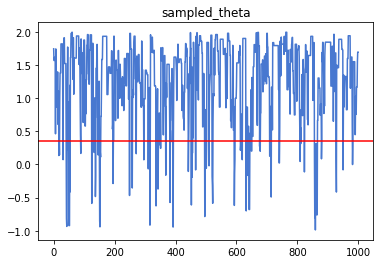

In [52]:
###=================== Trace the sampling =====================

# Plot sampled theta
plt.plot(sampled_theta, label="sampled_theta")
plt.axhline(y=true_theta, color="red")
plt.title("sampled_theta")
plt.show()

### What if we don't use Find_Map()

1. Implement in PyMC3

In [0]:
np.random.seed(123)
n_experiments = 4
theta_real = 0.35  # unkwon value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)
data

array([1, 0, 0, 0])

In [0]:
with pm.Model() as our_first_model:
    # a priori
    theta = pm.Beta('theta', alpha=1, beta=1)
    # likelihood
    y3 = pm.Bernoulli('y3', p=theta, observed=data)
    #y = pm.Binomial('theta',n=n_experimentos, p=theta, observed=sum(datos))
                                                                    # here we are removing find_Map 
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step) # here we had removed start parameter in the sample method as we have removed find_Map  

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [theta_logodds__]
The number of effective samples is smaller than 25% for some parameters.


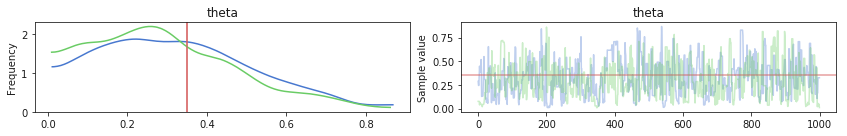

In [0]:
burnin = 0  # no burnin
chain = trace[burnin:]
pm.traceplot(chain, lines={'theta':theta_real});
plt.savefig('B04958_02_04.png', dpi=300, figsize=(5.5, 5.5))

As we can see from the outputs with Find_Map() and without Find_Map() the value of logP i.e log value of theta and sampling rate are not displaed if we dont use Find_map() method .Along with it there is a slight variation at the starting point of the KDE plot if we remove Find_Map() method.At the first line we
call find_MAP; this function calls optimization routines provided by SciPy and tries
to return the Maximum a Posteriori (MAP). Calling find_MAP is optional; sometimes
it works to provide a good starting point for the sampling method, sometimes it
does not help too much, so often we can avoid it.

2. Implement in Tensorflow

In [53]:
###====================== Generated data for the model ==============================
np.random.seed(123)
n_experiments = 4
true_theta = 0.35  # unkwon value in a real experiment
true_y = np.random.binomial(n=n_experiments, p=true_theta)
data = stats.bernoulli.rvs(p=true_theta, size=n_experiments)

print("The data set generated is:", data)

The data set generated is: [0 0 0 1]


In [0]:
###=================== Define the model ==========================
def joint_log_prob(theta, y):
  
  # prior
  rv_theta = tfd.Beta(1., 1.)
  
  # likelihood
  rv_y = tfd.Bernoulli(theta)
   
  return (rv_theta.log_prob(theta) + rv_y.log_prob(y))

def unnormalized_posterior(theta):
  return joint_log_prob(theta, true_y)

In [0]:
###=================== Sample the model =====================

# Initialize the HMC transition kernel.
num_results = int(10e2)
num_burnin_steps = int(1e3)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Wrap sample_chain in function
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
  
  is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  
  return samples, is_accepted

# Call run_chain
initial_state = tf.zeros(1)
samples, is_accepted = run_chain()
sampled_theta = samples

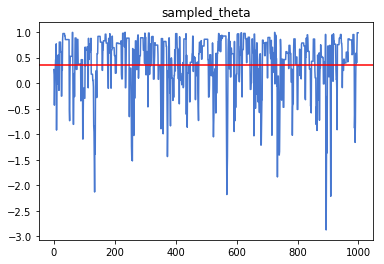

In [14]:
###=================== Trace the sampling =====================

# Plot sampled theta
plt.plot(sampled_theta, label="sampled_theta")
plt.axhline(y=true_theta, color="red")
plt.title("sampled_theta")
plt.show()

## 3.2)

### with burnin=0

1. Implement in PyMC3

In [0]:
np.random.seed(123)
n_experiments = 4
theta_real = 0.35  # unkwon value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)
data

array([1, 0, 0, 0])

In [0]:
with pm.Model() as our_first_model:
    # a priori
    theta = pm.Beta('theta', alpha=1, beta=1)
    # likelihood
    y = pm.Bernoulli('y', p=theta, observed=data)
    #y = pm.Binomial('theta',n=n_experimentos, p=theta, observed=sum(datos))
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, start=start)

logp = -2.7726, ||grad|| = 1: 100%|█████████████████████████████████████████████████████| 6/6 [00:00<00:00, 460.63it/s]
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [theta_logodds__]
The number of effective samples is smaller than 25% for some parameters.


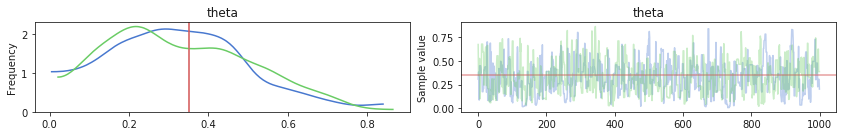

In [0]:
burnin = 0  # no burnin ( burnin =0)
chain = trace[burnin:]
pm.traceplot(chain, lines={'theta':theta_real});
plt.savefig('B04958_02_04.png', dpi=300, figsize=(5.5, 5.5))

2. Implement in Tensorflow

In [15]:
###====================== Generated data for the model ==============================
np.random.seed(123)
n_experiments = 4
true_theta = 0.35  # unkwon value in a real experiment
true_y = np.random.binomial(n=n_experiments, p=true_theta)
data = stats.bernoulli.rvs(p=true_theta, size=n_experiments)

print("The data set generated is:", data)

The data set generated is: [0 0 0 1]


In [0]:
###=================== Define the model ==========================
def joint_log_prob(theta, y):
  
  # prior
  rv_theta = tfd.Beta(1., 1.)
  
  # likelihood
  rv_y = tfd.Bernoulli(theta)
   
  return (rv_theta.log_prob(theta) + rv_y.log_prob(y))

def unnormalized_posterior(theta):
  return joint_log_prob(theta, true_y)

In [0]:
###=================== Sample the model =====================

# Initialize the HMC transition kernel.
num_results = int(10e2)
num_burnin_steps = 0

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Wrap sample_chain in function
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
  
  is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  
  return samples, is_accepted

# Call run_chain
initial_state = tf.zeros(1)
samples, is_accepted = run_chain()
sampled_theta = samples

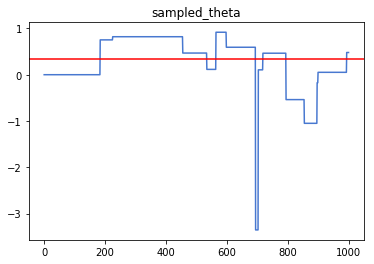

In [19]:
###=================== Trace the sampling =====================

# Plot sampled theta
plt.plot(sampled_theta, label="sampled_theta")
plt.axhline(y=true_theta, color="red")
plt.title("sampled_theta")
plt.show()

### with burnin=500 with find_Map()

1. Implement in PyMC3

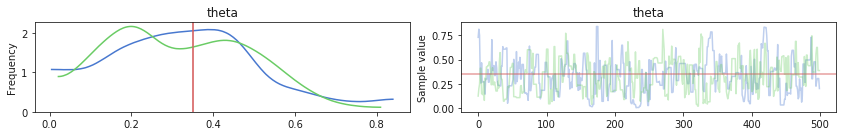

In [0]:
burnin = 500  # here we are taking the value of burnin ass 500
chain = trace[burnin:]
pm.traceplot(chain, lines={'theta':theta_real});
plt.savefig('B04958_02_04.png', dpi=300, figsize=(5.5, 5.5))

**From both the individual sampled values at each step during the sampling plots we can say that the sampling rate with burnin=0 is more than the sampling rate with burnin=500.So from this it can be concluded that the sampling rate decreases as the burnin value increases.** 

2. Implement in Tensorflow

In [20]:
###====================== Generated data for the model ==============================
np.random.seed(123)
n_experiments = 4
true_theta = 0.35  # unkwon value in a real experiment
true_y = np.random.binomial(n=n_experiments, p=true_theta)
data = stats.bernoulli.rvs(p=true_theta, size=n_experiments)

print("The data set generated is:", data)

The data set generated is: [0 0 0 1]


In [0]:
###=================== Define the model ==========================
def joint_log_prob(theta, y):
  
  # prior
  rv_theta = tfd.Beta(1., 1.)
  
  # likelihood
  rv_y = tfd.Bernoulli(theta)
   
  return (rv_theta.log_prob(theta) + rv_y.log_prob(y))

def unnormalized_posterior(theta):
  return joint_log_prob(theta, true_y)

In [0]:
###=================== Sample the model =====================

# Initialize the HMC transition kernel.
num_results = int(10e2)
num_burnin_steps = 500

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Wrap sample_chain in function
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
  
  is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  
  return samples, is_accepted

# Call run_chain
initial_state = tf.zeros(1)
samples, is_accepted = run_chain()
sampled_theta = samples

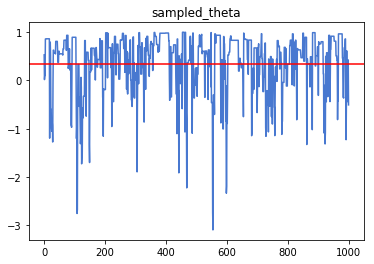

In [23]:
###=================== Trace the sampling =====================

# Plot sampled theta
plt.plot(sampled_theta, label="sampled_theta")
plt.axhline(y=true_theta, color="red")
plt.title("sampled_theta")
plt.show()

###  with burnin=0 without find_Map()

1. Implement in PyMC3

In [0]:
np.random.seed(123)
n_experiments = 4
theta_real = 0.35  # unkwon value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)
data

array([1, 0, 0, 0])

In [0]:
with pm.Model() as our_first_model:
    # a priori
    theta = pm.Beta('theta', alpha=1, beta=1)
    # likelihood
    y = pm.Bernoulli('y', p=theta, observed=data)
    #y = pm.Binomial('theta',n=n_experimentos, p=theta, observed=sum(datos))
                                                                        # here we are removing find_Map
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step)   # here we had removed start parameter in the sample method as we have removed find_Map

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [theta_logodds__]
The number of effective samples is smaller than 25% for some parameters.


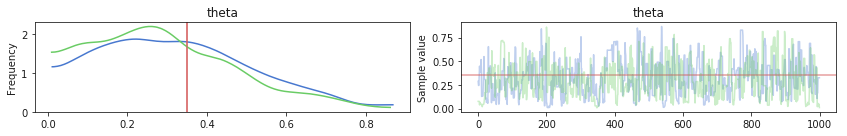

In [0]:
burnin = 0  # no burnin
chain = trace[burnin:]
pm.traceplot(chain, lines={'theta':theta_real});
plt.savefig('B04958_02_04.png', dpi=300, figsize=(5.5, 5.5))

** Calling find_MAP is optional; sometimes
it works to provide a good starting point for the sampling method, sometimes it
does not help too much, so often we can avoid it.Here if we remove find_Map() method we can see a little distortion in the starting point of KDE Plot.**


THe plot on the left side is KDE PLots.
KDE plots should look
like smooth curves. Often, as the number of data increases, the distribution of each
parameter will tend to become Gaussian-like; this is due to the law of the large
numbers. Of course, this is not always true. The plot on the right should look like
white noise; we are looking for good mixing. We should not see any recognizable
pattern, we should not see a curve going up or down, instead we want a curve
meandering around a single value.

2. Implement in Tensorflow

In [24]:
###====================== Generated data for the model ==============================
np.random.seed(123)
n_experiments = 4
true_theta = 0.35  # unkwon value in a real experiment
true_y = np.random.binomial(n=n_experiments, p=true_theta)
data = stats.bernoulli.rvs(p=true_theta, size=n_experiments)

print("The data set generated is:", data)

The data set generated is: [0 0 0 1]


In [0]:
###=================== Define the model ==========================
def joint_log_prob(theta, y):
  
  # prior
  rv_theta = tfd.Beta(1., 1.)
  
  # likelihood
  rv_y = tfd.Bernoulli(theta)
   
  return (rv_theta.log_prob(theta) + rv_y.log_prob(y))

def unnormalized_posterior(theta):
  return joint_log_prob(theta, true_y)

In [0]:
###=================== Sample the model =====================

# Initialize the HMC transition kernel.
num_results = int(10e2)
num_burnin_steps = 0

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Wrap sample_chain in function
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
  
  is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  
  return samples, is_accepted

# Call run_chain
initial_state = tf.zeros(1)
samples, is_accepted = run_chain()
sampled_theta = samples

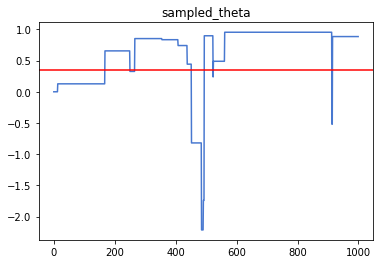

In [27]:
###=================== Trace the sampling =====================

# Plot sampled theta
plt.plot(sampled_theta, label="sampled_theta")
plt.axhline(y=true_theta, color="red")
plt.title("sampled_theta")
plt.show()

# Problem 4:

Take a look at the section "Estimating parameters of a linear regreession model" in https://people.duke.edu/~ccc14/sta-663/PyMC3.html .
Find 95% confidence interval of each parameter of the model: a, b and $\tau$. Compare your results with the results you would obtain using traditional linear regression. 
    

## Finding 95% confidence intervals of a,b, $\tau$ using given code of "Estimating paramters of a linear regression model

1. Implement in PyMC3

logp = -26.187, ||grad|| = 0.59879: 100%|█████████████████████████████████████████████| 28/28 [00:00<00:00, 186.49it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, b, a]


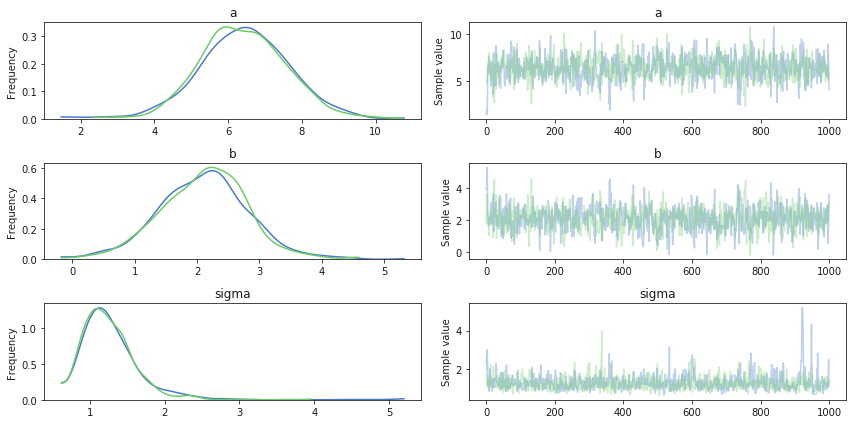

In [0]:
# observed data
n = 11
_a = 6
_b = 2
x = np.linspace(0, 1, n)
y = _a*x + _b + np.random.randn(n)
niter=1000
with pm.Model() as model:
    a = pm.Normal('a', mu=0, sd=20)
    b = pm.Normal('b', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)

    y_est = a*x + b # simple auxiliary variables

    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)
    # inference
    start = pm.find_MAP()
    step = pm.NUTS() # Hamiltonian MCMC with No U-Turn Sampler
    trace = pm.sample(niter, step, start, random_seed=123, progressbar=True)
    pm.traceplot(trace);

In [0]:
pm.summary(trace,alpha=.05).round(2)
    

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,5.35,0.90,0.03,3.65,7.31,669.0,1.0
b,2.43,0.52,0.02,1.46,3.47,680.0,1.0
sigma,0.90,0.26,0.01,0.50,1.41,523.0,1.0


** From the above the 95% confidence intervals of:
a(3.65,7.31)
b(1.46,3.47)
sigma(0.50,1.41) **


2. Implement in Tensorflow

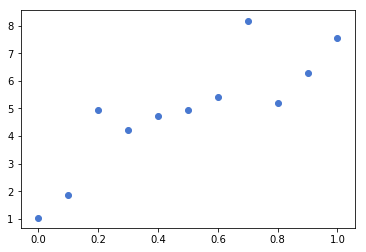

In [70]:
###====================== Generated data for the model ==============================
# observed data
np.random.seed(123)
n = 11
true_a = 6.
true_b = 2.
true_x = np.random.uniform(0., 1.)
x_value = np.linspace(0, 1, n)
true_y = true_a * true_x + true_b
y_value = true_a * x_value + true_b + np.random.randn(n)

# visulize the data
plt.scatter(x_value, y_value)

In [0]:
###=================== Define the model ==========================
def joint_log_prob(x, a, b, sigma, y):
  
  # prior
  rv_a = tfd.Normal(loc=0., scale=20.)
  rv_b = tfd.Normal(loc=0., scale=20.)
  rv_sigma = tfd.Uniform(low=0., high=20.)
  
  # simple auxiliary variables
  y_est = a * x + b
  
  # likelihood
  rv_y = tfd.Normal(loc=y_est, scale=sigma)
   
  return (rv_a.log_prob(a) + rv_b.log_prob(b) + rv_sigma.log_prob(sigma) + rv_y.log_prob(y))

def unnormalized_posterior(a, b, sigma):
  return joint_log_prob(true_x, a, b, sigma, true_y)

In [0]:
###=================== Sample the model =====================

# Initialize the HMC transition kernel.
num_results = int(10e2)
num_burnin_steps = 0

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Wrap sample_chain in function
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
  
  is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  
  return samples, is_accepted

# Call run_chain
initial_state = [tf.zeros(1), tf.zeros(1), tf.zeros(1)]
samples, is_accepted = run_chain()
sampled_a, sampled_b, sampled_sigma = samples

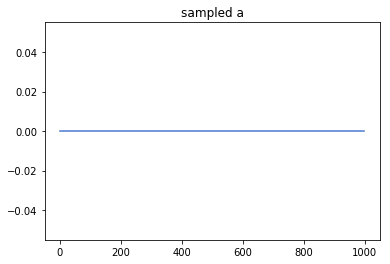

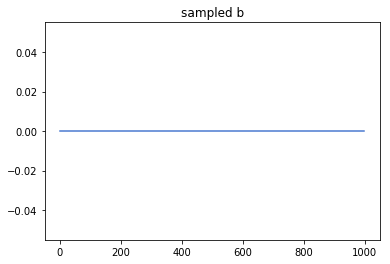

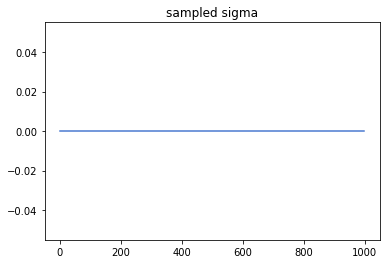

In [75]:
###=================== Trace the sampling =====================

# Plot sampled a
plt.plot(sampled_a, label="sampled a")
plt.title("sampled a")
plt.show()

# Plot sampled b
plt.plot(sampled_b, label="sampled b")
plt.title("sampled b")
plt.show()

# Plot sampled sigma
plt.plot(sampled_sigma, label="sampled sigma")
plt.title("sampled sigma")
plt.show()

## finding confidence interval using the traditional linear regression model 

In [0]:
# observed data
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import summary_table
n = 11
_a = 6
_b = 2
x = np.linspace(0, 1, n)
y = _a*x + _b + np.random.randn(n)
X = sm.add_constant(x)
regr = sm.OLS(y, X).fit()
print(regr.summary())

C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\HP\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     23.51
Date:                Mon, 19 Mar 2018   Prob (F-statistic):           0.000911
Time:                        16:47:05   Log-Likelihood:                -16.251
No. Observations:                  11   AIC:                             36.50
Df Residuals:                       9   BIC:                             37.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2286      0.661      3.371      0.0

** from this method the confidence interval of a is (2.89,7.946) , b is (0.733,3.724)**

**By observing the confidence intervals of a,b from both the methods we can say that pymc3 linear regression is accurate than traditional linear regression**